In [1]:
from typing import Annotated, List, Literal, TypedDict
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt

In [2]:
from dotenv import load_dotenv
from env_utils import doublecheck_env

# Load environment variables from .env
load_dotenv()

# Check and print results
doublecheck_env(".env")

LANGSMITH_API_KEY=****60e8
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ials
AZURE_OPENAI_PROJECT_ENDPOINT=****ject
AZURE_OPENAI_API_KEY=****U7lG
AZURE_OPENAI_ENDPOINT=****com/
AZURE_OPENAI_API_VERSION=****view
AZURE_OPENAI_DEPLOYMENT=****mini


In [3]:
from langchain.agents import create_agent

from dotenv import load_dotenv
import os
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT"),  # or your deployment
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),  # or your api version
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)



In [4]:
from pydantic import BaseModel, Field

# class State(BaseModel):
class State(TypedDict) :
    topic: str
    joke: str
    improved_joke: str
    final_joke: str



In [5]:
from typing import Literal

from langchain.tools import tool

def create_topic(state: State) -> State:
    print(f"create_topic: {state['topic']}")
    msg = llm.invoke(f"Generate a short joke on {state['topic']}")
    print(f"setting joke: {msg.content}")
    return State(joke = msg.content)


def improve_joke(state: State) -> State:
    print(f"improve_joke: {state['joke']}")
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    print(f"setting improved_joke: {msg.content}")
    return State(improved_joke=msg.content)

def create_final_joke(state: State) -> dict:
    print(f"create_final_joke: {state['improved_joke']}")
    msg = llm.invoke(f"Add a surprising twist to this joke {state['improved_joke']}")
    print(f"setting final_joke: {msg.content}")
    return State(final_joke=msg.content)

def check_punchline(state: State) -> Command[Literal["improve_joke", END]]:
    print(f"check_punchline: {state['joke']}")
    if state["joke"].endswith("?") or state["joke"].endswith("!"):
        print("sent to improve_joke")
        return Command(goto=["improve_joke"])
    else:
        print("ending here")
        return Command(goto=[END])  


In [6]:
builder = StateGraph(State)

builder.add_node("create_topic", create_topic)
builder.add_node("check_punchline", check_punchline)
builder.add_node("improve_joke", improve_joke)
builder.add_node("create_final_joke", create_final_joke)

builder.add_edge(START, "create_topic")
builder.add_edge("create_topic", "check_punchline")
builder.add_edge("improve_joke", "create_final_joke")
builder.add_edge("create_final_joke", END)
graph = builder.compile()


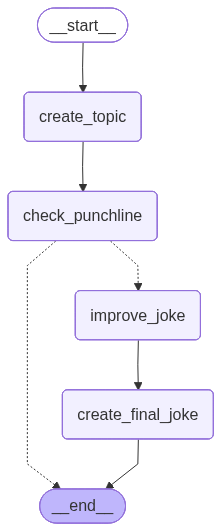

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
result = graph.invoke({
    "topic": "dogs", 
    "joke": "",
    "improved_joke": "",
    "final_joke": ""
    })
print(result)

create_topic: dogs
setting joke: Why did the dog sit in the shade? 

Because he didn’t want to become a hot dog!
check_punchline: Why did the dog sit in the shade? 

Because he didn’t want to become a hot dog!
sent to improve_joke
improve_joke: Why did the dog sit in the shade? 

Because he didn’t want to become a hot dog!
setting improved_joke: Why did the dog sit in the shade? 

Because he didn’t want to become a hot dog—he preferred to be a cool pup instead!
create_final_joke: Why did the dog sit in the shade? 

Because he didn’t want to become a hot dog—he preferred to be a cool pup instead!
setting final_joke: Why did the dog sit in the shade? 

Because he didn’t want to become a hot dog—he preferred to be a cool pup instead! But little did he know, the squirrel in the tree was planning a barbecue!
{'topic': 'dogs', 'joke': 'Why did the dog sit in the shade? \n\nBecause he didn’t want to become a hot dog!', 'improved_joke': 'Why did the dog sit in the shade? \n\nBecause he didn’t 